# **Applying DRL for FIR Filter Implementation - Stage 1 - Section 3 - Retry** 

## Scope - *MDP Modeling of the Adaptive FIR Filters*
References:- the book, *Deep Reinforcement Learning for Wireless Communications and Networking*

In [1]:
import os, sys, time, copy
import json
import wave
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
from scipy.fft import fft, rfft, fftshift, fftfreq
from scipy.signal import convolve, freqz

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, DDPG, HER, PPO, SAC, TD3
from stable_baselines3.common.base_class import BaseAlgorithm, VecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

sys.path.append('../')
from helper import to_min_size_int_array, Spectrum, LPF, apply_filter, mean_L1_dist, SNR, create_target_and_jammed_signals
from DDPG import DDPGAgent

2023-11-25 15:55:58.112090: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-25 15:55:58.146748: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 15:55:58.146784: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 15:55:58.146801: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 15:55:58.153295: I tensorflow/core/platform/cpu_feature_g

### **Building a Skeleton for the Receiver Environment**

In [2]:
class ReceiverEnvSkeleton(gym.Env):
    """
    A custom environment that follows the gym interface developed to immitate the receiver environment for the RL adaptive filter agent. 
    :param N: FIR filter length, must be an odd integer 
    :param S: buffer size at the receiver
    """

    # define constants 
    MIN_BUFFER_SIZE = 20

    def __init__(self, N:int, S:int):
        super(ReceiverEnvSkeleton, self).__init__()

        # ----- verifying input arguments and setting them as class atributes ----
        # filter length 
        if N%2 != 1:
            raise Exception(f"FIR filter length 'N' must be an odd integer: given {N}")
        self.N = N

        # signal partition size
        if S < self.MIN_BUFFER_SIZE:
            raise Exception(f"the buffer size 'S' must be larger than the MIN_BUFFER_SIZE, {self.MIN_BUFFER_SIZE}: given {S}")
        self.S = S
        # buffer size 
        self.buffer_size = S + N - 1

        # ----------------------------- Action Space -----------------------------
        # action - choosing the filter coefficients; 
        # NOT TUNING/ADJUSTING/CHANGING the coefficeints of an existing filter that the agent is not aware of 
        action_shape = (int((N+1)/2), )
        self.action_space = spaces.Box(low=-1, high=1, shape=action_shape, dtype=np.float32) # float16 -> float32

        # ----------------------------- State Space ------------------------------
        state_shape = (self.buffer_size, )
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=state_shape, dtype=np.int32)


    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)

        # set the agent back to the initial state 

        # return the initial state
        initial_state = self.observation_space.sample()
        info = {}

        # ******* make sure that the state returned by env.reset() is same as the end state of the previous episode to emulate a non-episodic agent-env interaction. *******
        return initial_state, info

    def step(self, action):

        next_state = self.observation_space.sample()
        reward = 0
        terminated = False
        truncated  = False
        info = {}
        return next_state, reward, terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass


##### Verifying the API of the Custom Skeleton Receiver Environment 
- use the SB3 in-built `check_env` function

In [7]:
env = ReceiverEnvSkeleton(N=5, S=100)
check_env(env)

### **Building a Uni-State Receiver Environment**

- DDPG is specified for episodic tasks, so we have to include episodes into our environment as well. 
- Here, there is no episode **termination** because there is no notion of learning being completed or achieving some end goal. 
- Therefore, we have to introduce some maximum number of steps per episode and **truncate** the episode once that maximum limit is reached. 
- Then, automatically, SB3 will reset the environment before continuing with another episode. 
- Now, we have to carefully overlook and control what is getting reset at these epiode switches **to eumulate a continous learning process** (a single long episode). 
- Since this environment has a single fixed state (i.e., resetting back to an initial state is not required), reset function only has to return the fixed state; we must not reset the counter since it allows to keep track the elapsed number of time steps of the agent-environment interaction. 
- For the simplicity of reusing an env class instance, resetting the counter is useful; otherwise, we would have to take a new instance of the environment each time we are going to debug/analyze the environment or to train a model. For this purpose, we can exploit the `options` input argumnet of the `reset` method API. 

In [6]:
target_signal, jammed_signal = create_target_and_jammed_signals('vignesh', truncation_freq=5_000, interference_center_freq=12_000)

audio name: 'vignesh'
sampling rate    : 44100 Hz
audio shape: (136477,)
data type: int16
MONO audio file...
truncating the spectrum at 5000Hz...
converting from float64 to <class 'numpy.int16'>; array ranges from min: -13841.346435316103 (>=-32768) to max: 14399.410754652867 (<=32767)
converting from float64 to <class 'numpy.int32'>; array ranges from min: -40397.67357435536 (>=-2147483648) to max: 41413.510195372364 (<=2147483647)


In [7]:
class UniStateReceiverEnv(gym.Env):
    """
    A custom environment developed in the accordance with gym environment API that immitates a single state environment. 
    i.e., the objective of the agent is going to be find the best filter that maximizes the reward for a fixed signal partition. 
    :param N: FIR filter length, must be an odd integer 
    :param S: buffer size at the receiver
    """

    # define constants 
    MIN_BUFFER_SIZE = 20
    EPISODE_LENGTH  = 100

    def __init__(self, N:int, S:int):
        super(UniStateReceiverEnv, self).__init__()

        # ----- verifying input arguments and setting them as class atributes ----
        # filter length 
        if N%2 != 1:
            raise Exception(f"FIR filter length 'N' must be an odd integer: given {N}")
        self.N = N

        # signal partition size
        if S < self.MIN_BUFFER_SIZE:
            raise Exception(f"the buffer size 'S' must be larger than the MIN_BUFFER_SIZE, {self.MIN_BUFFER_SIZE}: given {S}")
        self.S = S
        # buffer size 
        self.buffer_size = S + N - 1

        # ----------------------------- Action Space -----------------------------
        # action - choosing the filter coefficients from index 0 to (N-1)/2; 
        # NOT TUNING/ADJUSTING/CHANGING the coefficeints of an existing filter that the agent is not aware of 
        action_shape = (int((N+1)/2), )
        self.action_space = spaces.Box(low=-1, high=1, shape=action_shape, dtype=np.float32) # float16 -> float32

        # ----------------------------- State Space ------------------------------
        state_shape = (self.buffer_size, )
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=state_shape, dtype=np.int32)

        # ------------------------- other class atributes ------------------------
        self.state = jammed_signal[:self.buffer_size] # fixed state
        self.counter = 0 # a counter to keep track of the number of elapsed time steps of the environment

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=None)

        # set the agent back to the initial state 
        # in this case, we have only one state in the entire environment
        initial_state = self.state

        if options == 'reset_counter':
            self.counter = 0

        info = {}

        # return the initial state
        # make sure that the state returned by env.reset() is same as the end state of the previous episode to emulate a non-episodic agent-env interaction. 
        return initial_state, info

    def step(self, action):

        # increment the counter
        self.counter += 1

        # create the filter 
        filter = np.concatenate((action[-1:0:-1], action))

        # received signal partition in the buffer
        partition = self.state

        # apply the filter 
        filtered = apply_filter(filter, partition)[(self.N-1)//2 : (self.N-1)//2 + self.S]
        target   = target_signal[(self.N-1)//2 : (self.N-1)//2 + self.S]

        # calculate the reward (SNR)
        reward = SNR(target, filtered)
        if np.isnan(reward):
            raise Exception("reward value is not a number...")
        
        # truncating the episode
        truncated = False
        if self.counter % self.EPISODE_LENGTH == 0:
            truncated = True
        
        next_state = self.state 
        terminated = False
        info = {}
        
        return next_state, reward, terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass


##### step 1 - check the API of the custom UniStateReceiverEnv

In [8]:
env = UniStateReceiverEnv(N=5, S=100)
check_env(env)

##### step 2 - evaluate the custom UniStateReceiverEnv 
- We will develop our own function to evaluate the environment. 

In [6]:
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv

def Evaluate(
        model:BaseAlgorithm,
        env  :gym.Env|DummyVecEnv,
        n_eval_episodes:int,
        start:int = 0,
        end  :int = -1
    ):
    """
    A custom function to evaluate a DRL model (agent) in a specified env; the env will be reset completely before evaluation. 

    :param model: the DRL model
    :param env: an instance of the env; can be a gym environment or a SB3 DummyVecEnv
    :param n_eval_episodes: number of episodes to evaluate the model
    :param start: (for reward visulaization purposes) the start index of rewards array to plot 
    :param end: (for reward visulaization purposes) the end index of rewards array to plot 
    """

    rewards = []
    if isinstance(env, gym.Env):
        state, _ = env.reset(options='reset_counter') # full reset
        for _ in range(n_eval_episodes):
            done = False
            while not done:
                action, _ = model.predict(state, deterministic=True)
                state, reward, terminated, truncated, info = env.step(action)
                rewards.append(reward)
                done = terminated | truncated
            # after the end of an episode, manual env reset is required to be done for environments of type gym.Env
            # but, the behaviour of this env.reset() must be controlled carefully 
            # make sure that the state returned by env.reset() is same as the end state of the previous episode to emulate a non-episodic agent-env interaction. 
            state, _ = env.reset()

    elif isinstance(env, DummyVecEnv):
        state = env.reset(options='reset_counter') # full reset
        for _ in range(n_eval_episodes):
            done = False
            while not done:
                action, _ = model.predict(state, deterministic=True)
                state, reward, done, info = env.step(action)
                rewards.append(reward)
            # after the end of an episode, manual env reset is NOT required to be done for environments of type SB3 DummyVecEnv
            # but, the behaviour of this env.reset() must be controlled carefully 
            # make sure that the state returned by env.reset() is same as the end state of the previous episode to emulate a non-episodic agent-env interaction. 

    else:
        raise Exception("the provided env is not supported.")

    print(f"no. of steps: {len(rewards)}")

    plt.plot(rewards[start:end])
    plt.title(f"Observed Rewards [{start}:{end}]")
    plt.xlabel("time steps")
    plt.ylabel("rewards (SNR values)")

    return np.mean(rewards), np.std(rewards)

##### step 3 - launching DRL models
- Here, we will use DRL models from different DRl algorithms available in SB3 that are **suitable for continuous multi-dimensional action spaces** (`spaces.Box`).
> - A2C
> - DDPG
> - *HER*
> - PPO
> - SAC
> - TD3

In [9]:
uni_state_env = UniStateReceiverEnv(N=5, S=100)

# launch models
model_A2C  = A2C(policy='MlpPolicy', env=uni_state_env, verbose=1)
model_DDPG = DDPG(policy='MlpPolicy',env=uni_state_env, verbose=1)
model_PPO  = PPO(policy='MlpPolicy', env=uni_state_env, verbose=1)
model_SAC  = SAC(policy='MlpPolicy', env=uni_state_env, verbose=1)
model_TD3  = TD3(policy='MlpPolicy', env=uni_state_env, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


no. of steps: 100


(-7.688908482540756, 8.881784197001252e-16)

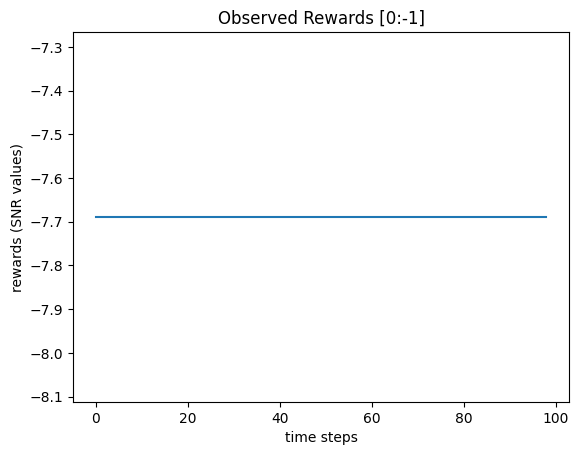

In [23]:
# DDPG
# evaluating a random DDPG agent
Evaluate(model_DDPG, uni_state_env, n_eval_episodes=1)

In [ ]:
# train the model
model_DDPG_ = model_DDPG.learn(total_timesteps=10_000)

no. of steps: 100


(-7.832980537634613, 1.7763568394002505e-15)

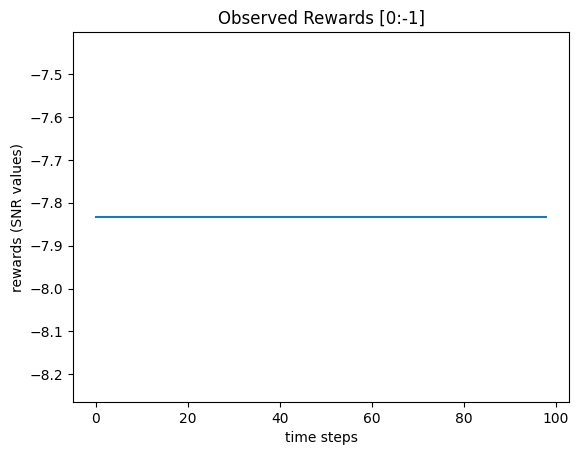

In [30]:
# evaluate the model after training
Evaluate(model_DDPG_, uni_state_env, n_eval_episodes=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
no. of steps: 100
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 100      |
|    ep_rew_mean        | -220     |
| time/                 |          |
|    fps                | 493      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.16    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 3.8      |
|    std                | 0.969    |
|    value_loss         | 0.851    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 100      |
|    ep_rew_mean        | -104     |
| time/                 |          |
|    fps                | 476      |


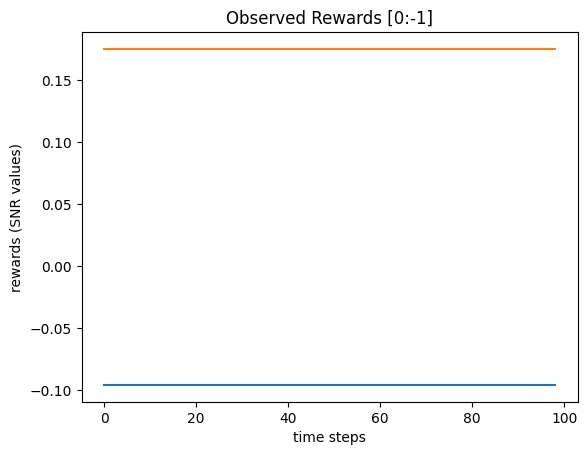

In [10]:
# initialize an A2C agent
model_A2C  = A2C(policy='MlpPolicy', env=uni_state_env, verbose=1)
before_training_reward_mean, before_training_reward_std = Evaluate(model_A2C, uni_state_env, n_eval_episodes=1)
model_A2C_ = model_A2C.learn(total_timesteps=10_000)
after_training_reward_mean, after_training_reward_std   = Evaluate(model_A2C_, uni_state_env, n_eval_episodes=1)

In [11]:
print(before_training_reward_mean, before_training_reward_std)
print(after_training_reward_mean, after_training_reward_std)

-0.09597850785373224 2.7755575615628914e-17
0.17522274206437172 8.326672684688674e-17


### **Building the Complete Environment**

In [ ]:
class ReceiverEnv(gym.Env):
    """
    A custom environment developed in the accordance with gym environment API that immitates a single state environment. 
    i.e., the objective of the agent is going to be find the best filter that maximizes the reward for a fixed signal partition. 
    :param N: FIR filter length, must be an odd integer 
    :param S: buffer size at the receiver
    :param cut_off_freq: the frequency to truncate the audio spectrum to generate the target signal; equivalent to the ideal cut-off frequency of the learned filter
    :param interference_center_freq: the frequency to shift the target spectrum to generate the non-overlapping interference
    :param audio_json: path specifying a json file that contains the names of audio wav files the environment can access\
    put the audio file names without the .wav extension in a json array inside the file
    """

    # define constants 
    MIN_BUFFER_SIZE = 10 # RAISE THIS LATER!!!
    EPISODE_LENGTH  = 10 # np.inf

    def __init__(self, N:int, S:int, cut_off_freq:int, interference_center_freq:int, audio_json:str = 'audio_files/audio_files.json'):
        super(ReceiverEnv, self).__init__()

        # ----- verifying input arguments and setting them as class atributes ----
        # filter length 
        if N%2 != 1:
            raise Exception(f"FIR filter length 'N' must be an odd integer: given {N}")
        self.N = N

        # signal partition size
        if S < self.MIN_BUFFER_SIZE:
            raise Exception(f"the buffer size 'S' must be larger than the MIN_BUFFER_SIZE, {self.MIN_BUFFER_SIZE}: given {S}")
        self.S = S
        # buffer size 
        self.buffer_size = S + N - 1

        # other parameters
        self.cut_off_freq = cut_off_freq
        self.interference_center_freq = interference_center_freq
        self.audio_json = audio_json

        # ----------------------------- Action Space -----------------------------
        # action - choosing the filter coefficients from index 0 to (N-1)/2; 
        # NOT TUNING/ADJUSTING/CHANGING the coefficeints of an existing filter that the agent is not aware of 
        action_shape = (int((N+1)/2), )
        self.action_space = spaces.Box(low=-1, high=1, shape=action_shape, dtype=np.float32) # float16 -> float32

        # ----------------------------- State Space ------------------------------
        state_shape = (self.buffer_size, )
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=state_shape, dtype=np.int32)

        # ------------------------- other class attributes ------------------------
        self.counter = 0 # a counter to keep track of the number of elapsed time steps of the environment
        self.episode_counter = 0 # a counter to keep track of the number of time stepe in a single episode

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=None)

        # for each episode, choose an audio signal randomly
        with open(self.audio_json) as audio_json_file:
            audio_names = json.load(audio_json_file)
        # the first audio will be kept for testing only, so `low=1`
        i = np.random.randint(low=1, high=len(audio_names))
        # create the target and jammed signals
        target_signal, jammed_signal = create_target_and_jammed_signals(audio_names[i], self.cut_off_freq, self.interference_center_freq)
        self.target_signal = target_signal
        self.jammed_signal = jammed_signal

        # return the initial state 
        self.state = jammed_signal[:self.buffer_size]

        # reset the counters
        if options == 'reset_counter':
            self.counter = 0
        self.episode_counter = 0

        info = {}

        # return the initial state
        # make sure that the state returned by env.reset() is same as the end state of the previous episode to emulate a non-episodic agent-env interaction. 
        return self.state, info

    def step(self, action):

        # increment the counters
        self.counter += 1
        self.episode_counter += 1

        # create the filter 
        filter = np.concatenate((action[-1:0:-1], action))

        # received signal partition in the buffer
        partition = self.state
        # print(f"step: {self.counter}, state: {partition}")

        # generating the next state
        terminated = False
        if (self.S * self.counter) + self.buffer_size >= len(self.jammed_signal):
            terminated = True
        else:
            self.state = self.jammed_signal[(self.S * self.counter) : (self.S * self.counter) + self.buffer_size]

        # apply the filter 
        filtered = apply_filter(filter, partition)[(self.N-1)//2 : (self.N-1)//2 + self.S]
        target   = self.target_signal[(self.N-1)//2 + self.S * (self.counter - 1) : (self.N-1)//2 + self.S * (self.counter - 1) + self.S]
        # print(f"filtered: {filtered}")
        # print(f"target:   {target}")

        # calculate the reward (SNR)
        reward = SNR(target, filtered)
        if np.isnan(reward):
            raise Exception("reward value is not a number...")
        print(f"step: {self.counter}, SNR: {reward}")
        
        # truncating the episode
        truncated = False
        if self.episode_counter == self.EPISODE_LENGTH:
            truncated = True
        
        info = {}

        return self.state, reward, terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass


In [ ]:
if __name__ == '__main__':
    env = ReceiverEnv()
    
    agent = DDPGAgent(
        input_dims=env.observation_space.shape,
        n_actions=env.action_space.shape[0],
        alpha=0.01,
        beta=0.1,
        gamma=0,
        tau=0.001,
        critic_fc1=20,
        critic_fc2=10,
        actor_fc1=128,
        actor_fc2=128,
        batch_size=64,
        buffer_size=10_000,
        noise=1.0
    )
    n_episodes = 50

    figure_file = 'plots/pendulum.png'
    best_score = env.reward_range[0] # minimum reward possible
    score_history = []
    load_checkpoint = False

    if load_checkpoint:
        n_steps = 0
        while n_steps <= agent.batch_size:
            observation, _ = env.reset()
            action = env.action_space.sample()
            new_observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated | truncated
            agent.remember(observation, action, reward, new_observation, done)
            n_steps += 1
        agent.learn()
        # your model is only going to completely created when learned
        # the input layer of the critic network is only initialized when started training. 
        agent.load_models()
        evaluate = True
    else:
        evaluate = False

    observation, _ = env.reset()
    # action_before_training = agent.choose_action(observation, evaluate=True)
    for i in range(n_episodes):
        done = False
        score = 0
        action_buffer = []
        while not done:
            action = agent.choose_action(observation, evaluate)
            action_buffer.append(action)
            new_observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated | truncated
            score += reward
            agent.remember(observation, action, reward, new_observation, done)
            if not load_checkpoint:
                agent.learn()
            observation = new_observation
        score_history.append(score)
        avg_score = np.mean(score_history[-10:])

        if score> best_score:
            best_score = score
            if not load_checkpoint:
                agent.save_models()

        print(f"episode:{i}, score:{np.round(score, 4)}, avg score:{np.round(avg_score, 4)}")
        print(f"average action: {np.mean(np.array(action_buffer), axis=0)}")

    if not load_checkpoint:
        x = np.arange(1, 1+n_episodes)
        plot_learning_curve(x, score_history, figure_file)

    action_after_training = agent.choose_action(observation, evaluate=True)


In [47]:
# # testing the env
# jammed_signal = np.arange(100)
# target_signal = np.arange(100)
# env = ReceiverEnv(N=5, S=10)

# state, _ = env.reset(options='reset_counter')
# done = False
# while not done:
#     ideal_filter = np.array([1, 0, 0])
#     state, reward, terminated, truncated, _ = env.step(ideal_filter)
#     done = terminated | truncated

step: 1, state: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
filtered: [ 2  3  4  5  6  7  8  9 10 11]
target:   [ 2  3  4  5  6  7  8  9 10 11]
SNR: inf
step: 2, state: [10 11 12 13 14 15 16 17 18 19 20 21 22 23]
filtered: [12 13 14 15 16 17 18 19 20 21]
target:   [12 13 14 15 16 17 18 19 20 21]
SNR: inf
step: 3, state: [20 21 22 23 24 25 26 27 28 29 30 31 32 33]
filtered: [22 23 24 25 26 27 28 29 30 31]
target:   [22 23 24 25 26 27 28 29 30 31]
SNR: inf
step: 4, state: [30 31 32 33 34 35 36 37 38 39 40 41 42 43]
filtered: [32 33 34 35 36 37 38 39 40 41]
target:   [32 33 34 35 36 37 38 39 40 41]
SNR: inf
step: 5, state: [40 41 42 43 44 45 46 47 48 49 50 51 52 53]
filtered: [42 43 44 45 46 47 48 49 50 51]
target:   [42 43 44 45 46 47 48 49 50 51]
SNR: inf
step: 6, state: [50 51 52 53 54 55 56 57 58 59 60 61 62 63]
filtered: [52 53 54 55 56 57 58 59 60 61]
target:   [52 53 54 55 56 57 58 59 60 61]
SNR: inf
step: 7, state: [60 61 62 63 64 65 66 67 68 69 70 71 72 73]
filtered: [62 63 64 65